In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


## Loading meme data

In [2]:
meme = pd.read_csv('../data/processed/rwa.csv')

print(meme.shape)
meme.head()

(52339, 10)


,timestamp,open,high,low,close,volume,name,symbol,id,category
0,1633564800,5.042830,5.735786,1.592713,4.328322,6.928812e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
1,1633651200,4.331047,4.816305,3.071839,3.072047,5.498833e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
2,1633737600,3.111525,4.397213,2.799058,3.809395,6.617815e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
3,1633824000,3.793354,4.296038,3.322740,3.378479,2.602116e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
4,1633910400,3.549780,4.871195,3.076625,4.122230,4.414149e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa


In [3]:
meme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52339 entries, 0 to 52338
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  52339 non-null  int64  
 1   open       52339 non-null  float64
 2   high       52339 non-null  float64
 3   low        52339 non-null  float64
 4   close      52339 non-null  float64
 5   volume     52339 non-null  float64
 6   name       52339 non-null  object 
 7   symbol     52339 non-null  object 
 8   id         52339 non-null  object 
 9   category   52339 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 4.0+ MB


In [4]:
meme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52339 entries, 0 to 52338
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  52339 non-null  int64  
 1   open       52339 non-null  float64
 2   high       52339 non-null  float64
 3   low        52339 non-null  float64
 4   close      52339 non-null  float64
 5   volume     52339 non-null  float64
 6   name       52339 non-null  object 
 7   symbol     52339 non-null  object 
 8   id         52339 non-null  object 
 9   category   52339 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 4.0+ MB


## Preprocessing data

In [5]:
def removing_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    duplicates = pd.read_csv('../data/raw/duplicates.csv')
    for index, row in duplicates.iterrows():
        id = row['id']
        category = row['category']
        df = df[~((df['id'] == id) & (df['category'] == category))]
    return df

In [6]:
meme = removing_duplicates(meme)

### Capping time series

Capping the first timestamp of each token with the most common one in order to avoid error when predicting.

In [7]:
def capping_time_series(df: pd.DataFrame) -> pd.DataFrame:
    token_info = meme.groupby('id')['name'].value_counts()
    mean = np.floor(token_info.mean()).astype(int)
    ids_to_keep = token_info[token_info > 365].index.get_level_values(0).unique()
    filtered_meme = meme[meme['id'].isin(ids_to_keep)]
    first_timestamps = filtered_meme.groupby('id').timestamp.min()
    last_timestamps = filtered_meme.groupby('id').timestamp.max()
    max_first_timestamp = first_timestamps.max()
    min_last_timestamp = last_timestamps.min()
    return filtered_meme[filtered_meme['timestamp'] <= min_last_timestamp]

In [8]:
meme = capping_time_series(meme)

In [9]:
# check how many tokens left
token_info2 = meme.groupby('id')['name'].value_counts()
token_info2.describe()

count      36.000000
mean     1438.916667
std       595.488773
min       445.000000
25%      1041.500000
50%      1272.500000
75%      1546.500000
max      3067.000000
Name: count, dtype: float64

In [10]:
def timestamp_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

In [11]:
meme = timestamp_to_datetime(meme)

In [12]:
# reset the index
meme.reset_index(drop=True, inplace=True)
meme.head()

,timestamp,open,high,low,close,volume,name,symbol,id,category
0,2021-10-07,5.042830,5.735786,1.592713,4.328322,6.928812e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
1,2021-10-08,4.331047,4.816305,3.071839,3.072047,5.498833e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
2,2021-10-09,3.111525,4.397213,2.799058,3.809395,6.617815e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
3,2021-10-10,3.793354,4.296038,3.322740,3.378479,2.602116e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa
4,2021-10-11,3.549780,4.871195,3.076625,4.122230,4.414149e+07,Ribbon Finance,RBN,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,rwa


### Scaling

In [13]:
def scaling(df: pd.DataFrame) -> pd.DataFrame:
    series_scaler = StandardScaler()
    exog_scaler = StandardScaler()
    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    df['days_until_halving'] = df['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    df[['open', 'high', 'low', 'close', 'volume']] = series_scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])
    df['days_until_halving'] = exog_scaler.fit_transform(df[['days_until_halving']])
    return df, series_scaler, exog_scaler

In [14]:
meme, series_scaler, exog_scaler = scaling(meme)

In [15]:
# SHOW NUMBER UNIQUE TOKENS
meme['id'].nunique()

36

In [16]:
# create a function to plot the time series of each token in a loop
def plot_time_series(df: pd.DataFrame, n: int) -> None:
    ids = df['id'].unique()
    for i in range(n):
        id = ids[i]
        token = df[df['id'] == id]
        plt.figure(figsize=(15, 5))
        plt.plot(token['timestamp'], token['close'])
        plt.title(f'Token ID: {id}')
        plt.show()

In [17]:
# plot_time_series(meme, 20)

In [18]:
def create_series_exog(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data['seconds'] = data['timestamp'].apply(lambda x: x.timestamp())
    
    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    data['week_sin'] = np.sin(data['seconds'] * (2 * np.pi / week))
    data['week_cos'] = np.cos(data['seconds'] * (2 * np.pi / week))
    data['month_sin'] = np.sin(data['seconds'] * (2 * np.pi / month))
    data['month_cos'] = np.cos(data['seconds'] * (2 * np.pi / month))

    series = data[['timestamp', 'id', 'close', 'open', 'high', 'low', 'volume']]
    exog = data[['timestamp', 'id', 'days_until_halving']]
    return series, exog

def create_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    last_timestamp = df['timestamp'].max()
    future_dates = pd.date_range(start=last_timestamp + timedelta(days=1), periods=days, freq='D')
    
    future_data = pd.DataFrame({'timestamp': future_dates})
    future_data['seconds'] = future_data['timestamp'].apply(lambda x: x.timestamp())

    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    future_data['week_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / week))
    future_data['week_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / week))
    future_data['month_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / month))
    future_data['month_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / month))

    # Assuming 'id' remains the same for future data
    future_data['id'] = df['id'].iloc[0]

    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    future_data['days_until_halving'] = future_data['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    

    exog_future = future_data[['timestamp', 'id', 'days_until_halving']]
    exog_future.loc[:, 'days_until_halving'] = exog_scaler.transform(exog_future[['days_until_halving']])
    return exog_future

def create_all_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    future_exog_list = []
    
    for id, group in df.groupby('id'):
        future_exog = create_future_exog(group, days)
        future_exog_list.append(future_exog)
    
    all_future_exog = pd.concat(future_exog_list, ignore_index=True)
    return all_future_exog

In [19]:
series, exog = create_series_exog(meme)
future_exog = create_all_future_exog(meme, days=60)

In [20]:
features = ['close', 'open', 'high', 'low']

series_dict = series_long_to_dict(
                 data=series, 
                 series_id='id', 
                 index='timestamp', 
                 values= 'close', 
                 freq='D')

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

future_exog_dict = exog_long_to_dict(
    data      = future_exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

In [21]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# # Ensure there are enough colors
# if len(colors) < len(series_dict):
#     colors = colors * (len(series_dict) // len(colors) + 1)
# fig, axs = plt.subplots(27, 1, figsize=(20, 20), sharex=True)
# for i, s in enumerate(series_dict.values()):
#     axs[i].plot(s, label=s.name, color=colors[i])
#     axs[i].legend(loc='upper right', fontsize=8)
#     axs[i].tick_params(axis='both', labelsize=8)

In [22]:
def train_forecaster(series_dict: dict, exog_dict: exog_long_to_dict) -> ForecasterAutoregMultiSeries:
    regressor = LGBMRegressor(random_state=123, max_depth=5)
    forecaster = ForecasterAutoregMultiSeries(
                    regressor          = regressor,
                    lags               = 20,
                    encoding           = "ordinal",
                    dropna_from_series = False
                )
    
    forecaster.fit(series=series_dict, exog=exog_dict,suppress_warnings=True)
    
    return forecaster

In [23]:
forecaster = train_forecaster(series_dict, exog_dict)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 51119, number of used features: 22
[LightGBM] [Info] Start training from score 0.000207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [24]:
def predict_X_days(days_to_predict: int, future_exog_dict: exog_long_to_dict) -> pd.DataFrame:
    return forecaster.predict(steps=days_to_predict, exog=future_exog_dict, suppress_warnings=True)

In [25]:
predictions_60_days = predict_X_days(7, future_exog_dict)

In [26]:
predictions_60_days.head()

,0d0d9689-bf75-41ee-9555-aa2f2ca0186b,0f2d0434-2ff5-4166-8d59-5cb1e5b102e1,13af58e4-0242-4aa0-8d09-e0aaa262f761,19850b5a-a264-4954-a312-67d15c77f347,1c1cd416-b027-4d73-9d4d-0a9edc63524d,20a20296-c751-4011-88fa-fc2b8b0a8564,2db6b38a-681a-4514-9d67-691e319597ee,317d6ffb-c0b3-43c1-a88a-e19ab22d6171,39a5cc70-09c6-4e20-899e-131507186776,39b71592-9e16-4198-8ca5-3b19a3f41dd3,...,c0da60ef-b73f-45bd-8466-e90432406e4c,c46470b3-5614-4dd3-a286-59a600fad94f,cb1eec26-bd87-4585-a3f1-568ad28d3ef2,cb43529e-f4a4-4f18-a348-116ad35c9351,ce222383-2753-44d4-b9ef-2dd67a7ea730,d3540108-d1d6-4bd4-ae37-5a5287ecf9af,db7344b5-586a-4e9f-917f-1ce09831decd,eb9e9e28-13b8-4355-a70b-d4ae2a4ba724,f086ee5f-e8c6-42ae-9c65-e2cb33879196,fefc437d-46fa-4470-9ffe-e6c7219a1f9d
2024-10-16,-0.198295,-0.199148,-0.199148,-0.199148,-0.198755,-0.199148,-0.113733,-0.198669,-0.199044,-0.199148,...,-0.195421,-0.199136,-0.199148,-0.199006,-0.199148,-0.198830,-0.199099,-0.180187,-0.013554,-0.199100
2024-10-17,-0.198120,-0.199058,-0.199058,-0.199058,-0.198642,-0.199058,-0.113733,-0.198550,-0.198972,-0.199058,...,-0.195421,-0.199058,-0.199058,-0.198908,-0.199058,-0.198744,-0.199044,-0.180111,-0.013554,-0.199010
2024-10-18,-0.197920,-0.199024,-0.199024,-0.199024,-0.198625,-0.199024,-0.113733,-0.198416,-0.198879,-0.199024,...,-0.195421,-0.199024,-0.199024,-0.198879,-0.199024,-0.198642,-0.199009,-0.180111,-0.013554,-0.198911
2024-10-19,-0.197920,-0.198908,-0.198908,-0.198908,-0.198625,-0.198908,-0.113733,-0.198295,-0.198744,-0.198908,...,-0.195421,-0.198908,-0.198908,-0.198744,-0.198908,-0.198625,-0.198858,-0.180111,-0.013554,-0.198781
2024-10-20,-0.197920,-0.198830,-0.198830,-0.198830,-0.198625,-0.198830,-0.113733,-0.198120,-0.198642,-0.198830,...,-0.195421,-0.198830,-0.198830,-0.198642,-0.198830,-0.198625,-0.198744,-0.180111,-0.013554,-0.198594


In [27]:
def plot_predictions(series_dict, predictions_x_days, steps_ahead=60, start_date='', max_coins=None):
    tokens = list(series_dict.keys())
    
    if max_coins:
        tokens = tokens[:max_coins]
    
    for token_id in tokens:
        historical_data = series_dict[token_id]
        
        # Create a timeline for the predictions (future dates after the last historical data point)
        last_date = historical_data.index[-1]
        future_dates = pd.date_range(start=last_date, periods=steps_ahead+1, freq='D')[1:]  # Skip the last date
        
        # Get the predicted values for the token
        if token_id in predictions_x_days.columns:
            predictions = pd.Series(predictions_x_days[token_id], index=future_dates, name='Predictions')
        else:
            continue
        
        # Concatenate historical data with predictions
        combined_data = pd.concat([historical_data, predictions])
        
        if start_date != '':
            combined_data = combined_data[combined_data.index >= start_date]
        
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.plot(combined_data.index, combined_data, label='Historical + Predictions', color='blue')
        plt.axvline(x=last_date, color='red', linestyle='--', label='Start of Predictions')
        plt.title(f'Token: {token_id} - Historical Data and {steps_ahead}-Day Forecast')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        
        # Display plot
        plt.show()

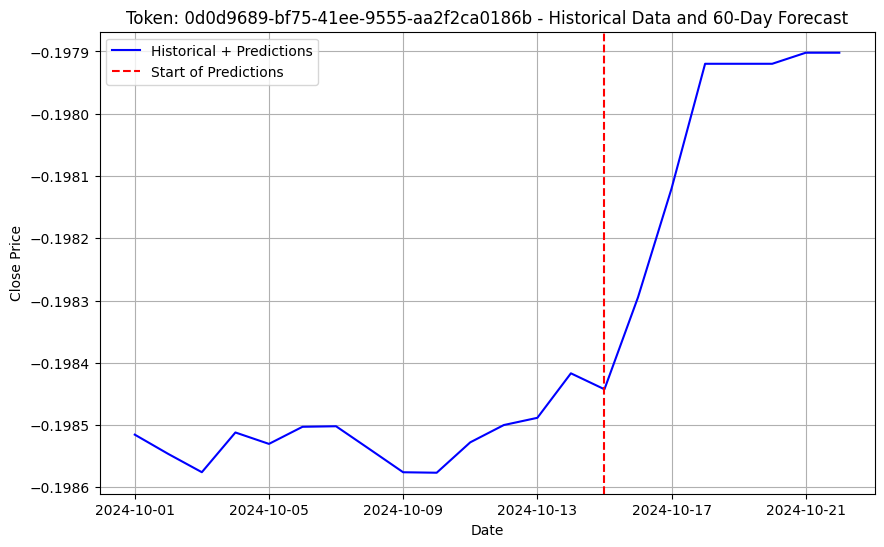

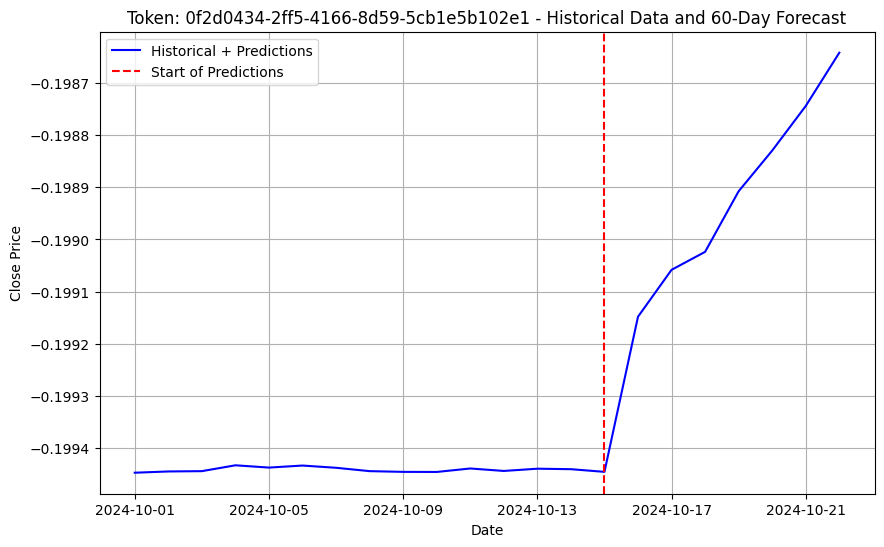

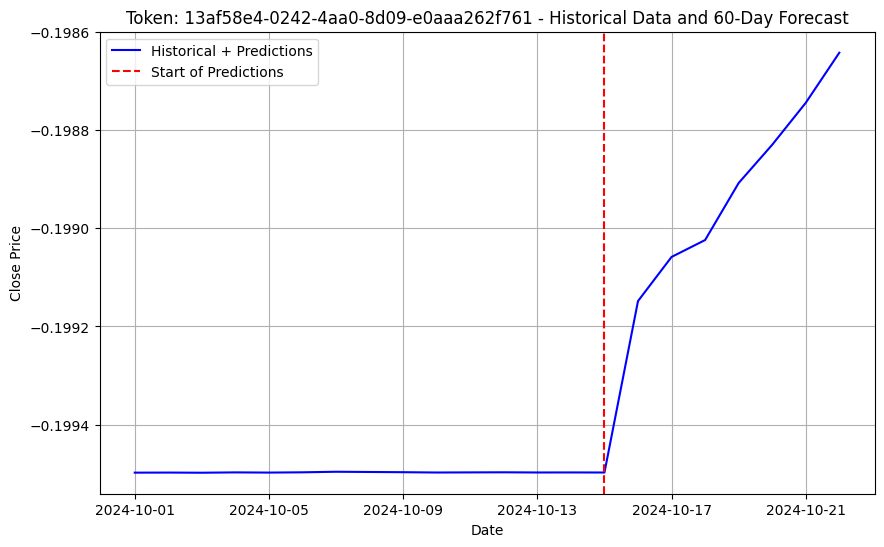

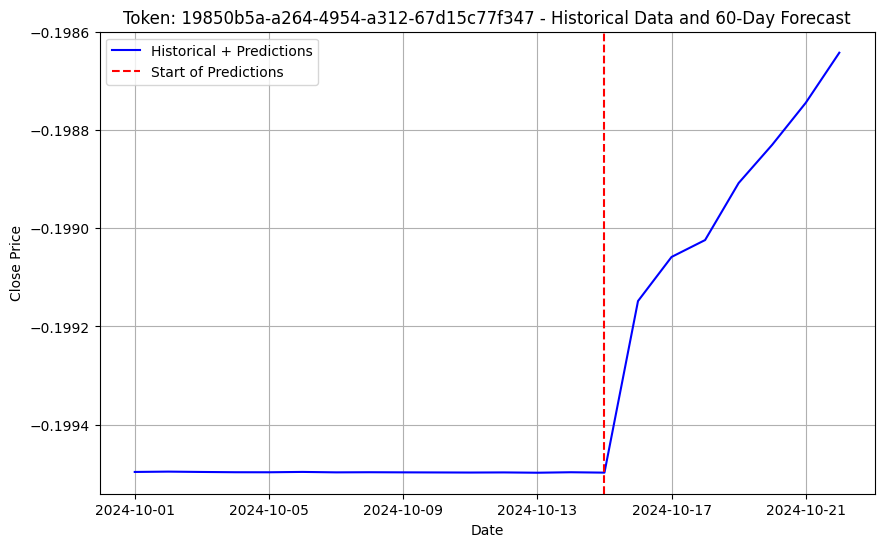

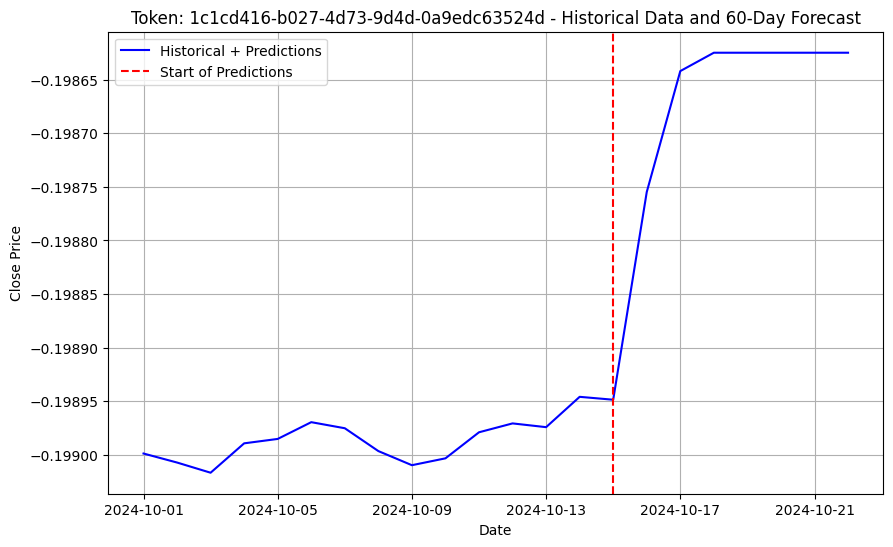

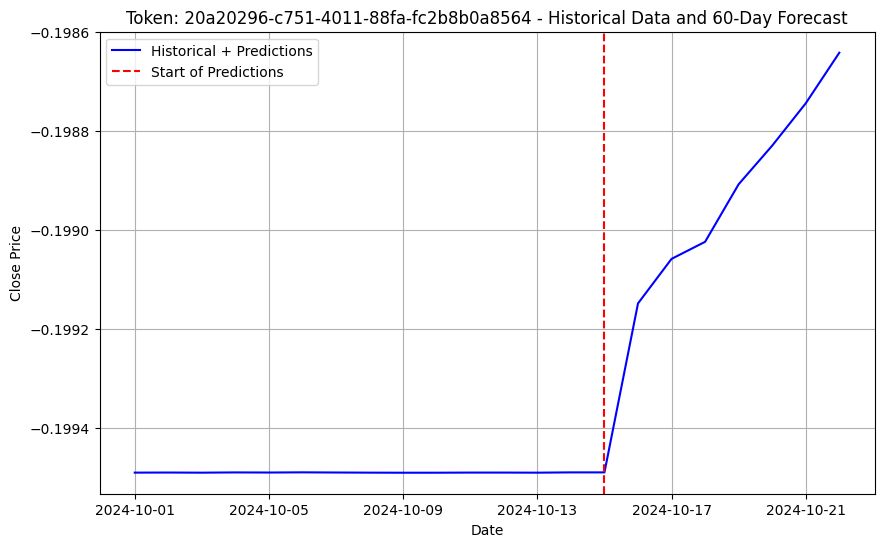

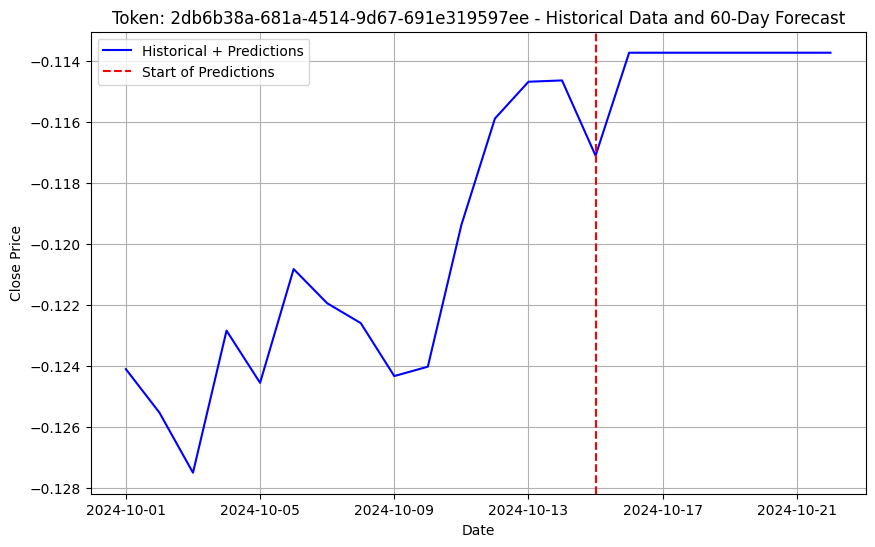

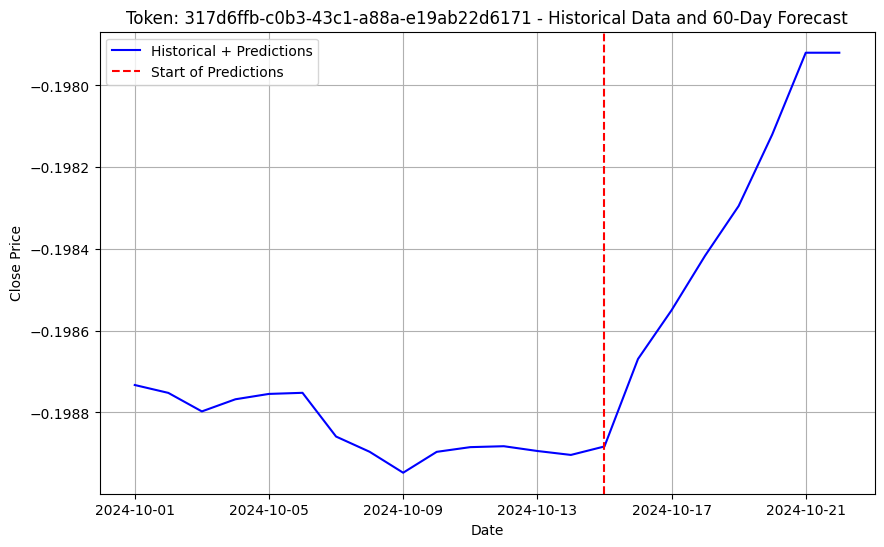

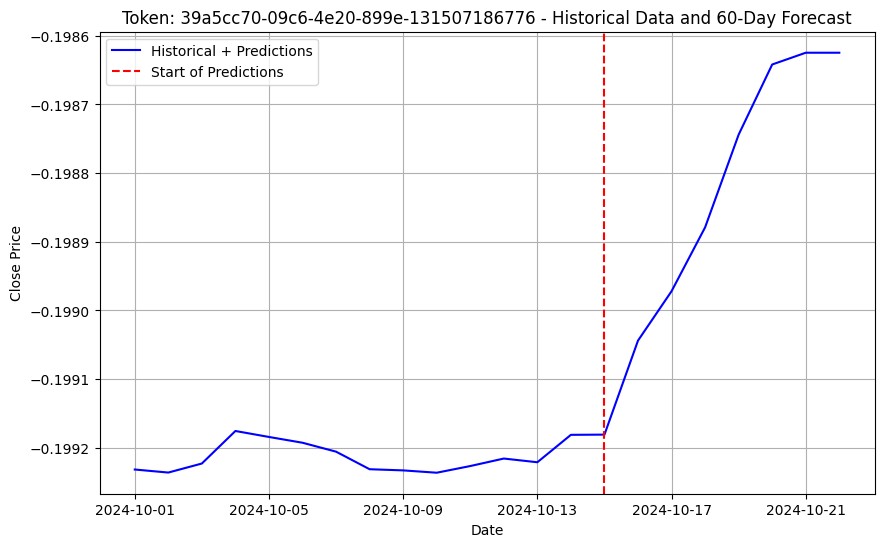

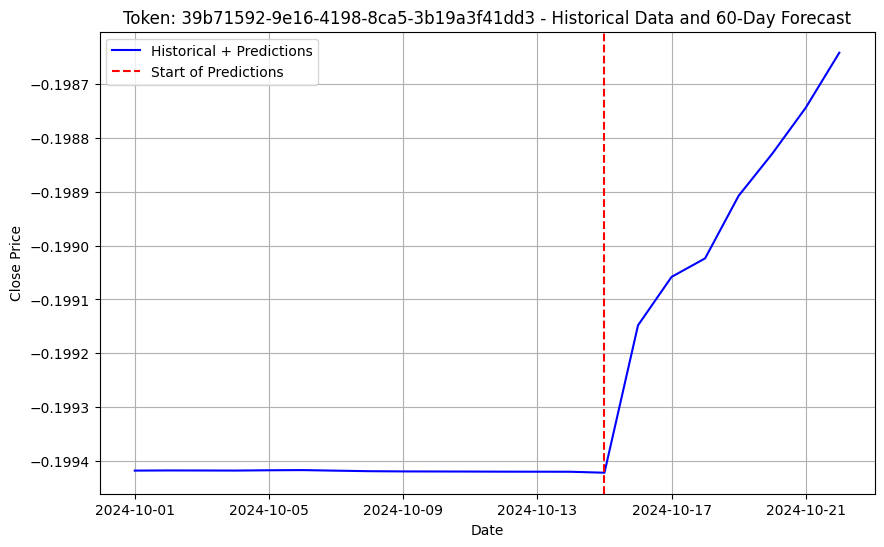

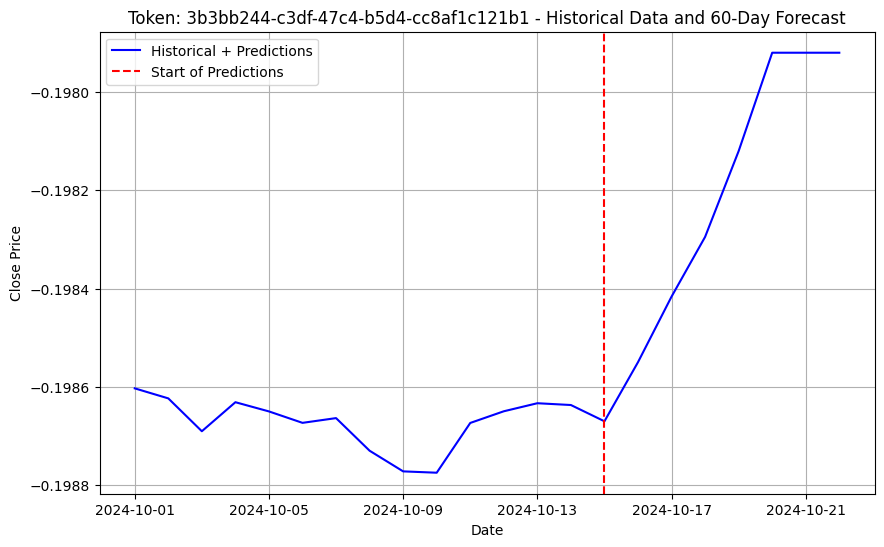

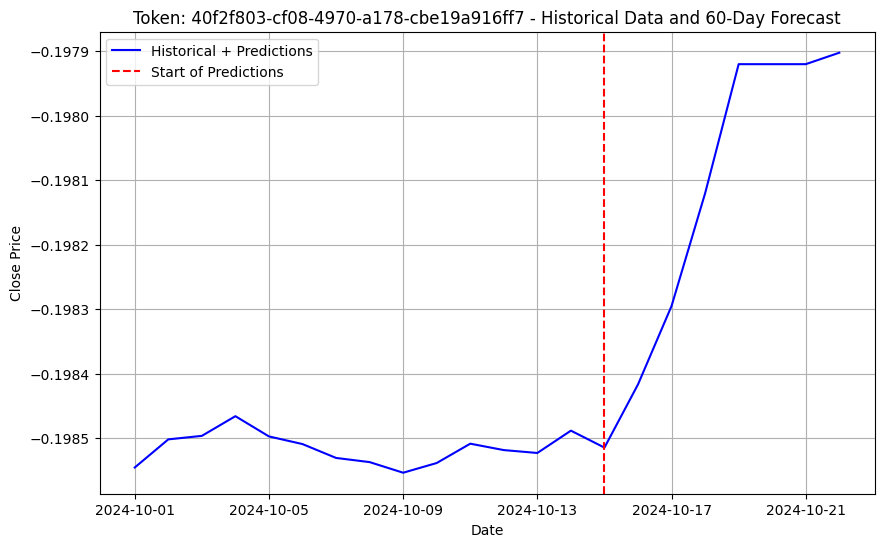

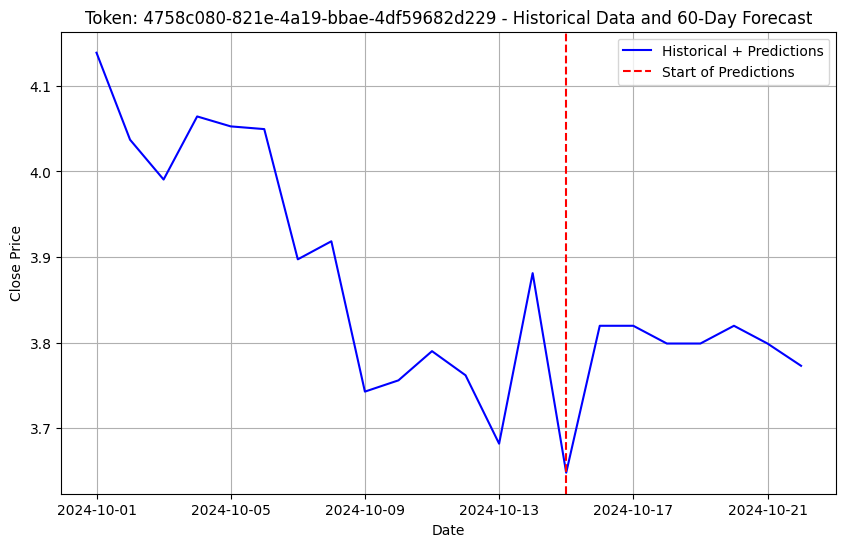

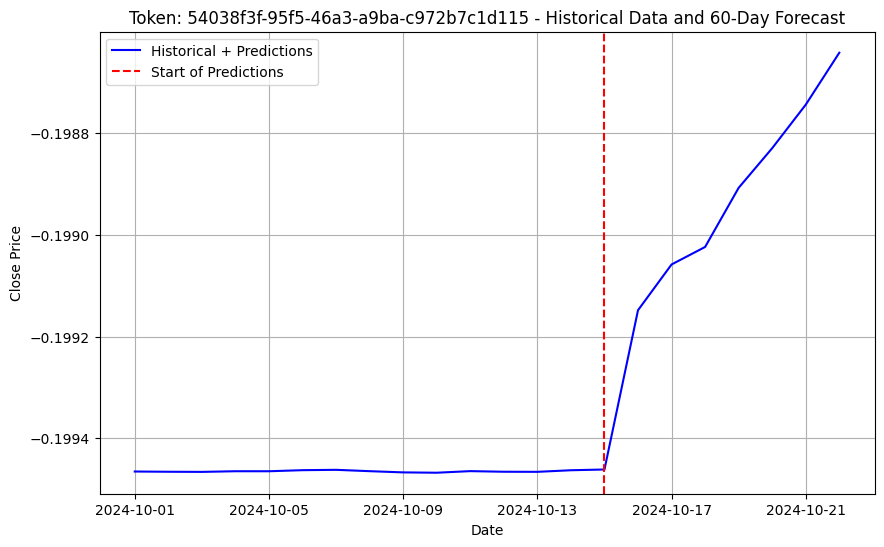

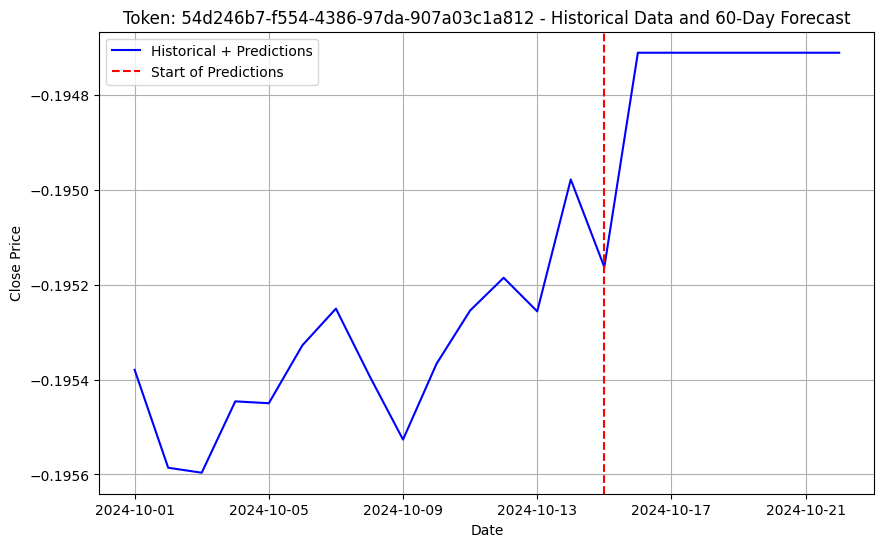

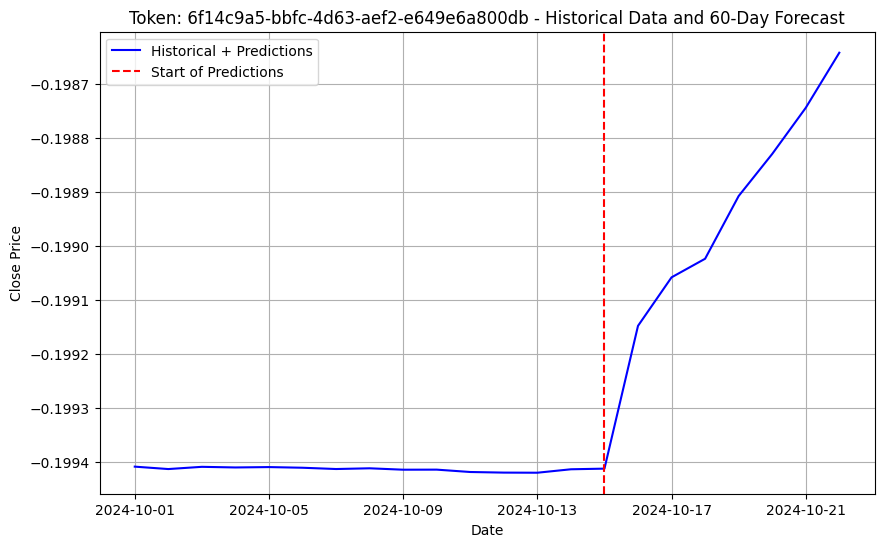

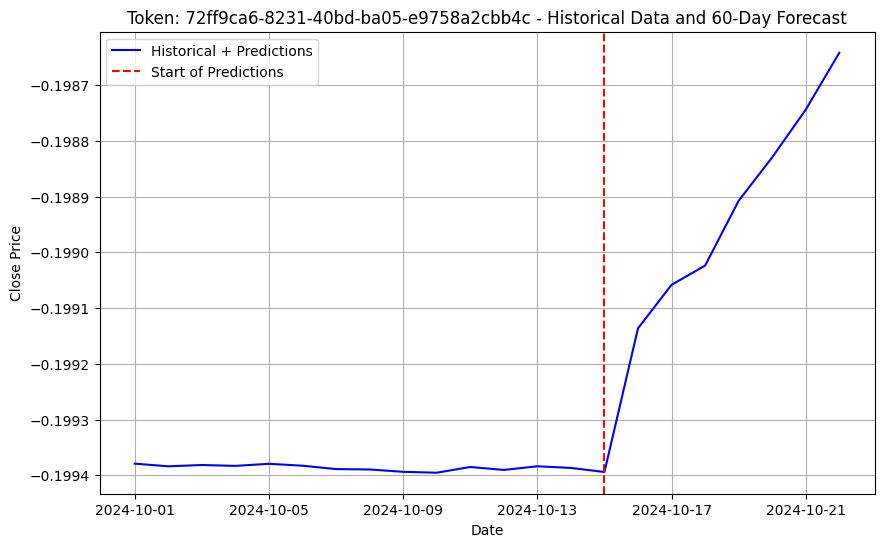

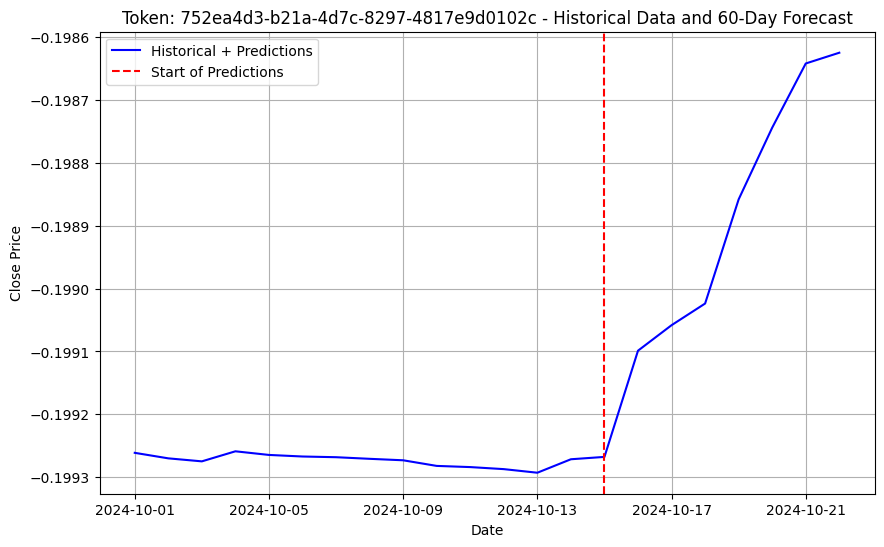

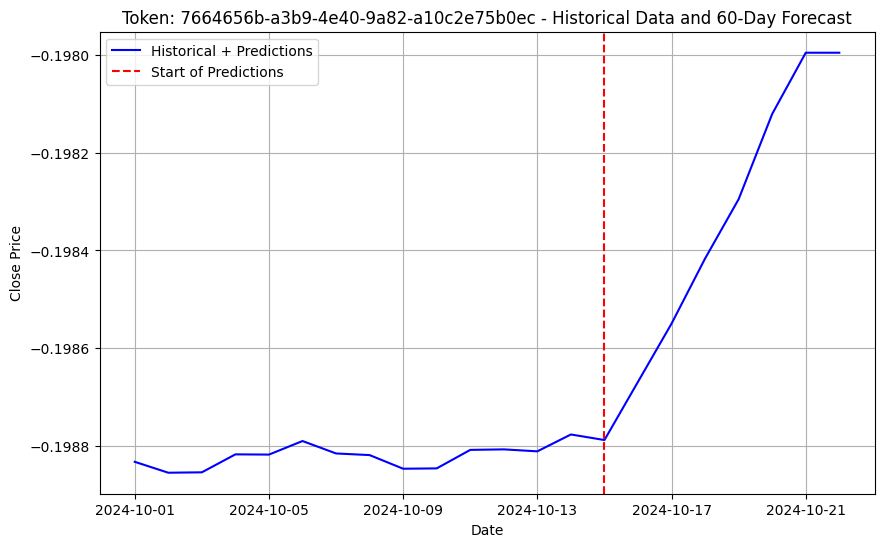

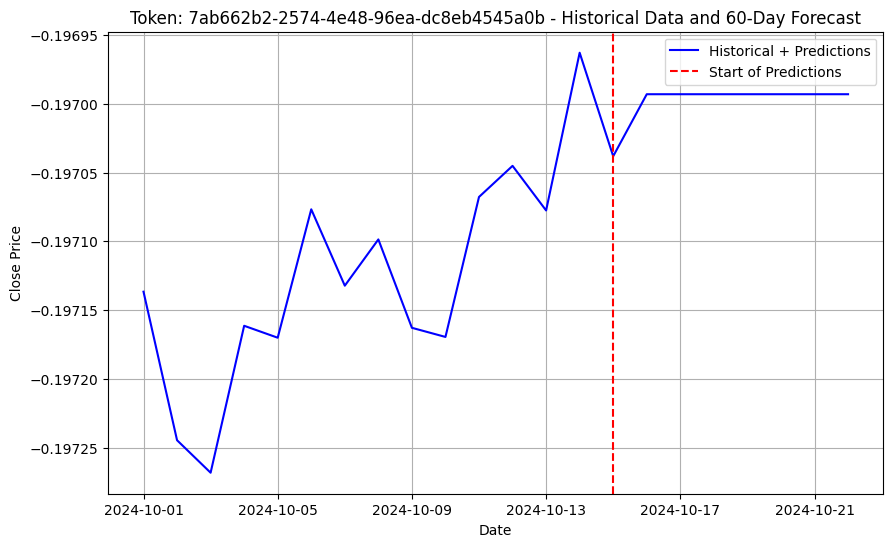

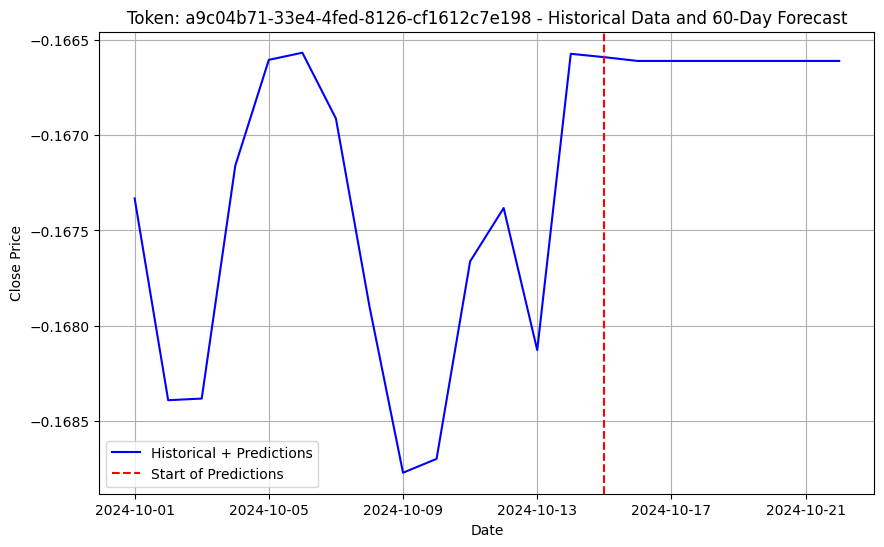

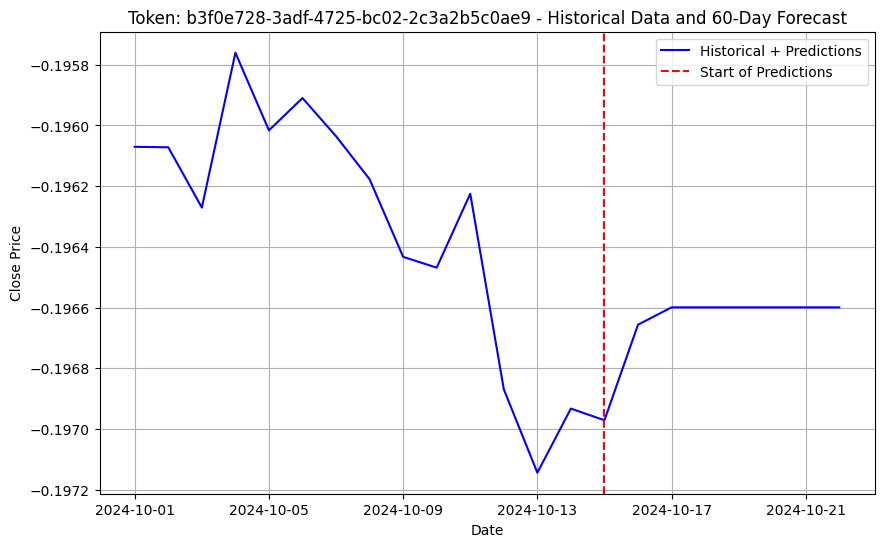

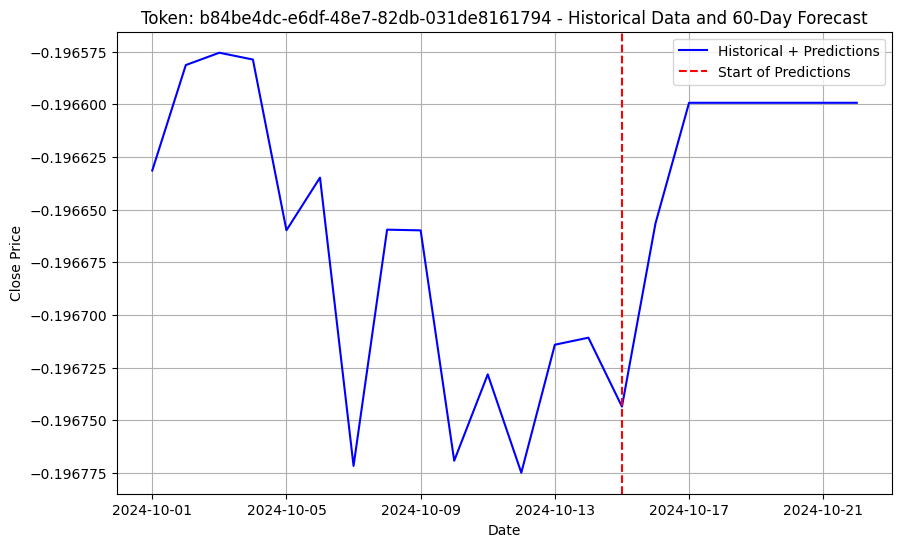

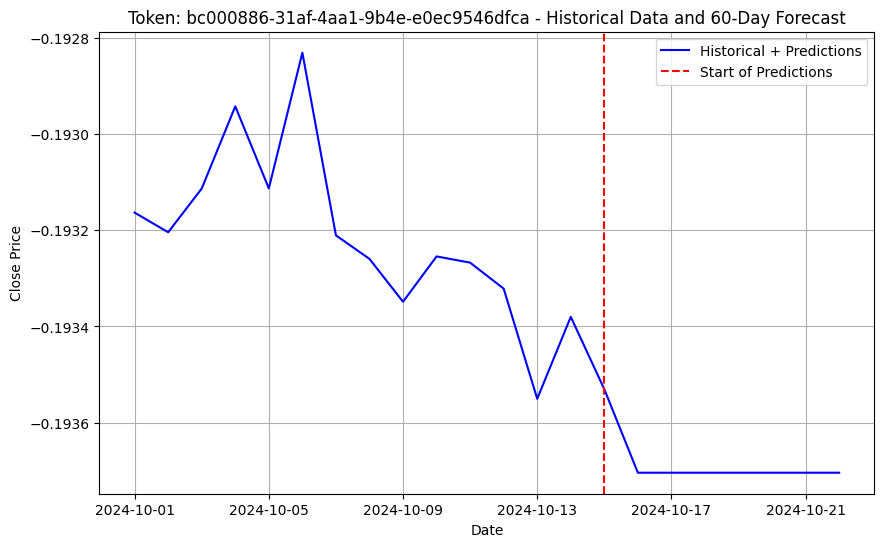

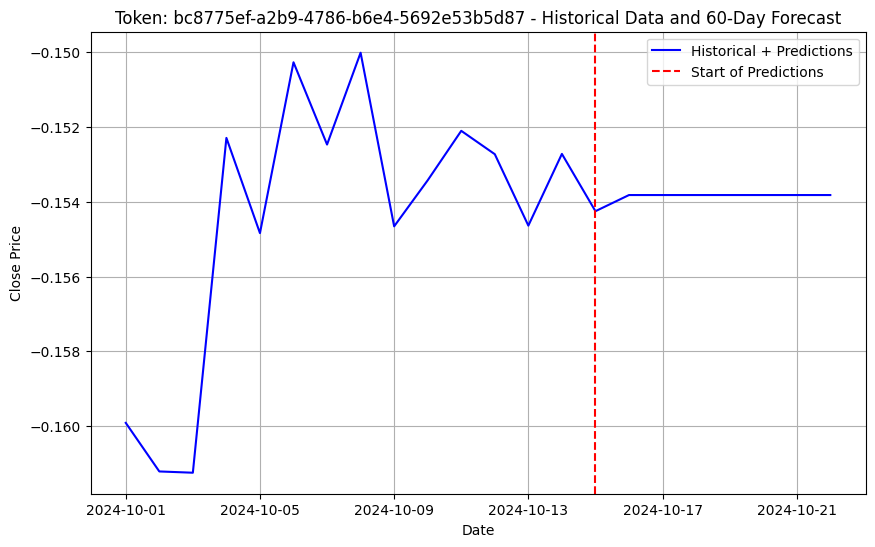

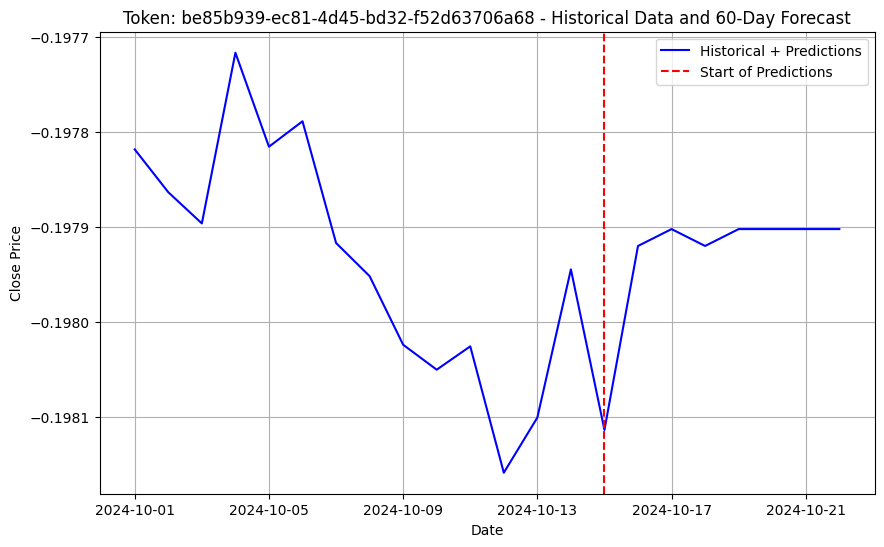

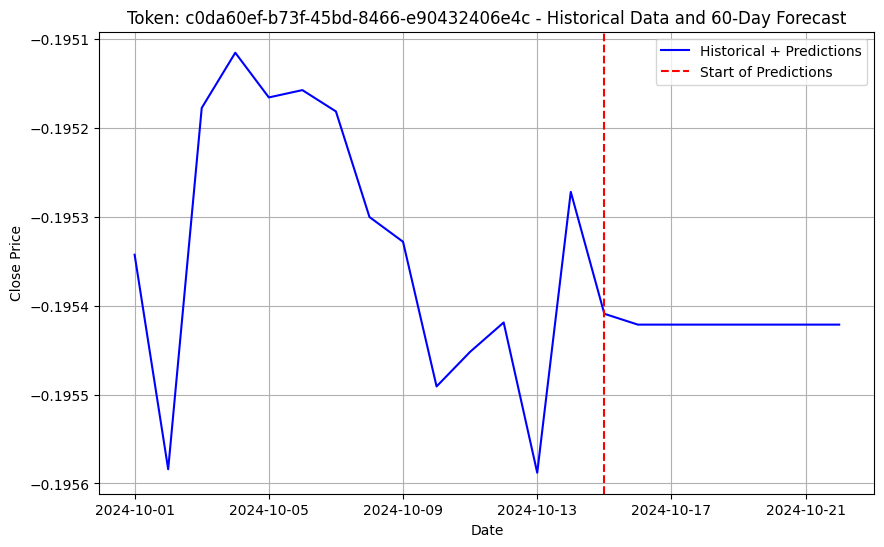

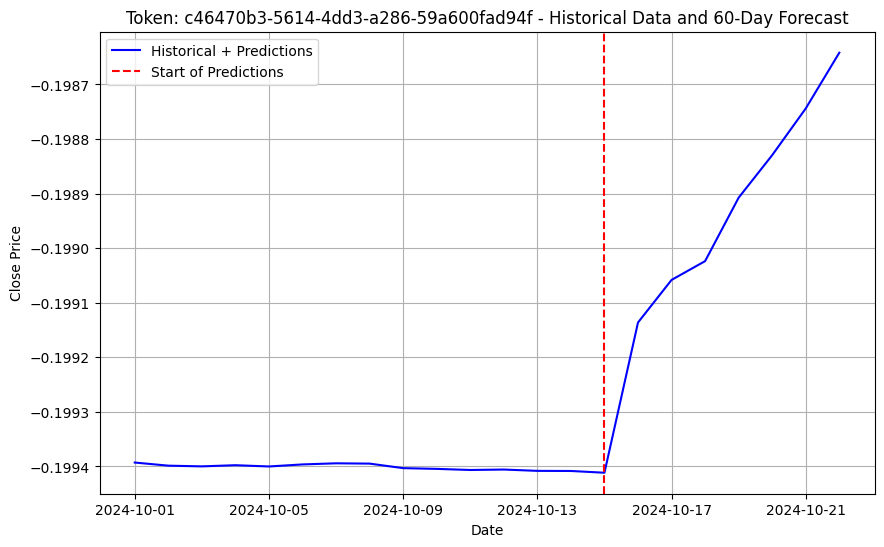

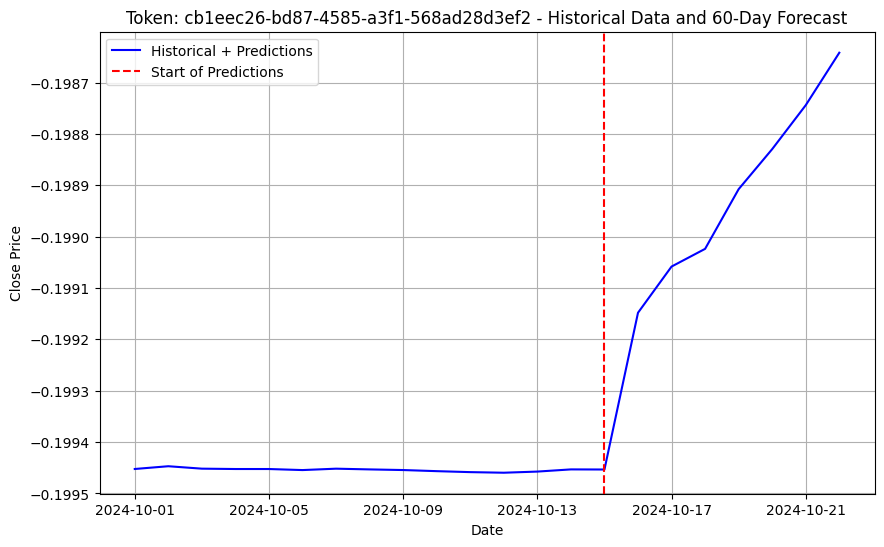

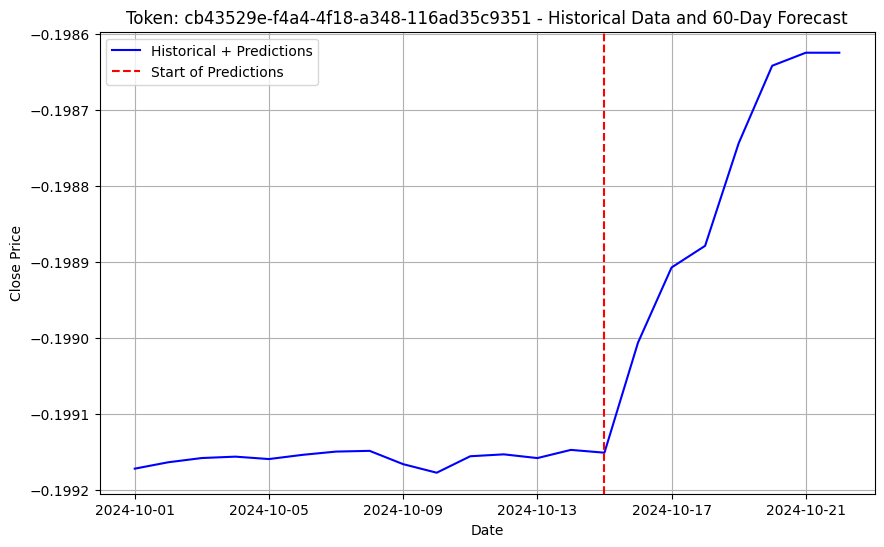

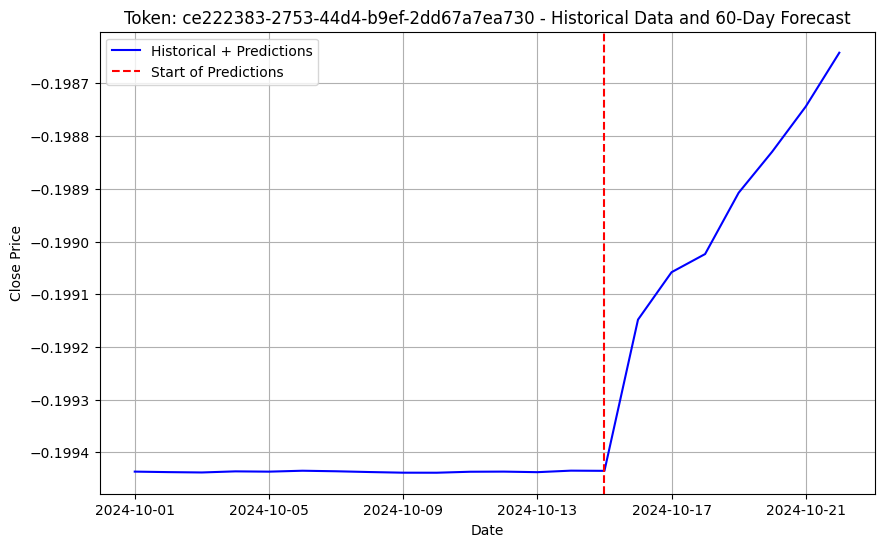

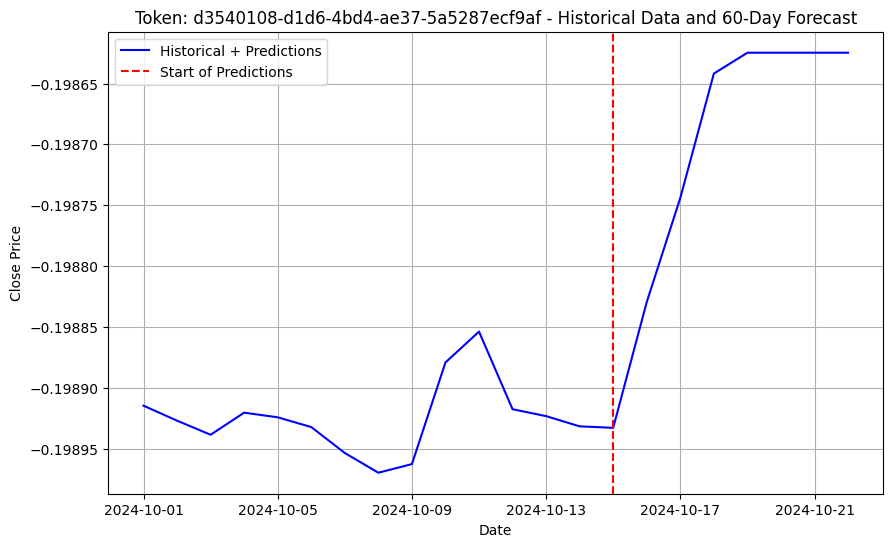

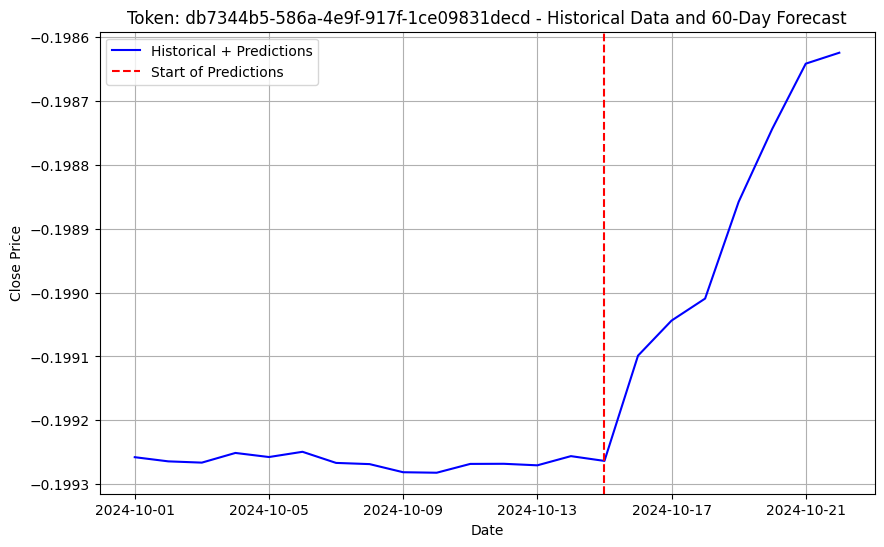

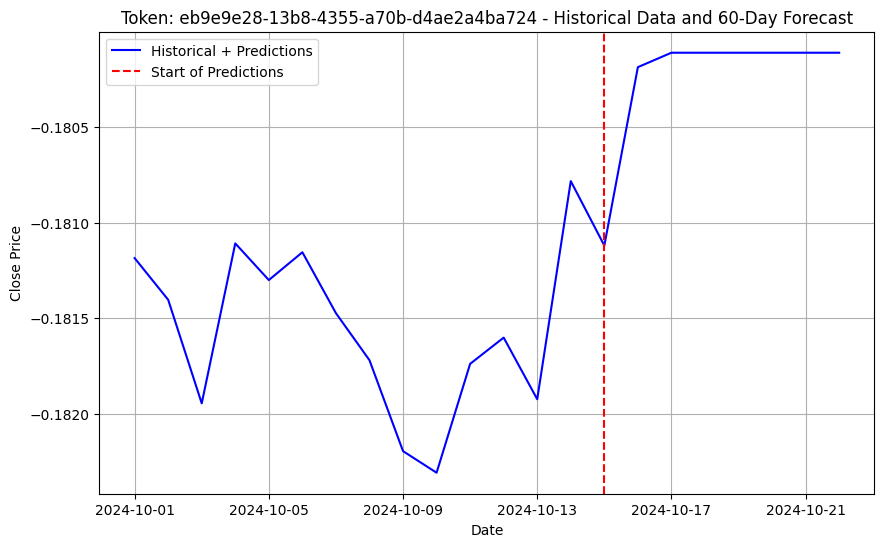

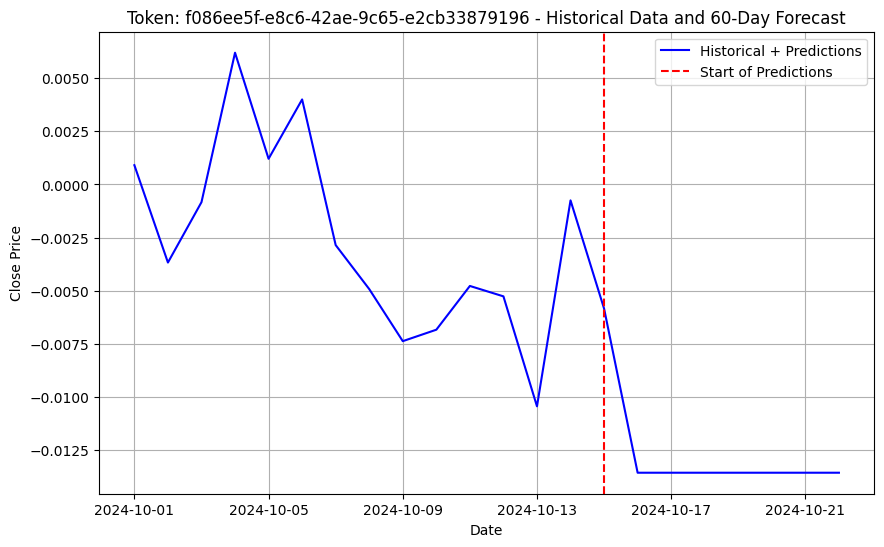

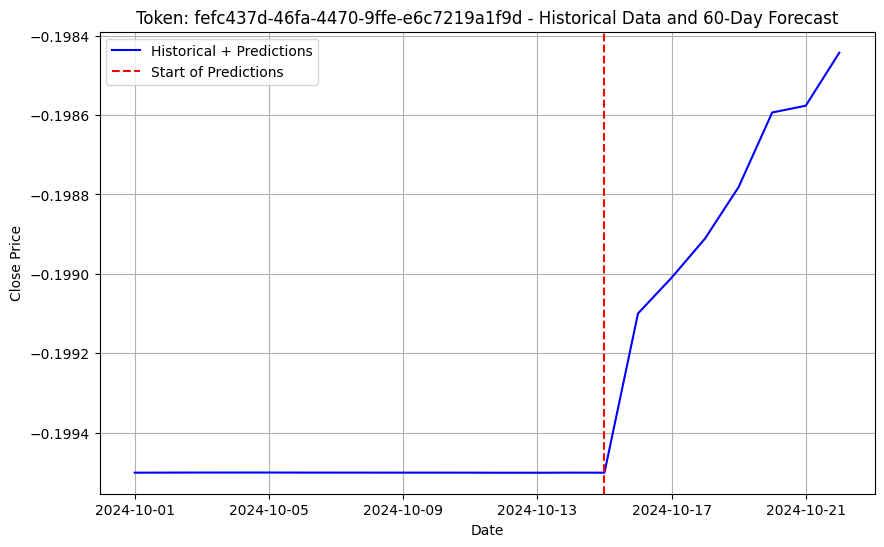

In [30]:
plot_predictions(series_dict, predictions_60_days, start_date='2024-10-01', steps_ahead=60, max_coins=50)